Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


apple grape dragonfruit strawberry


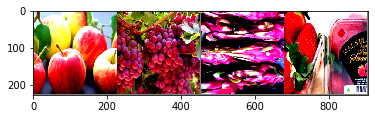

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
import datetime
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
import torchvision.models as models
%matplotlib inline

transform = transforms.Compose(
    [transforms.Resize((300,400)), 
     transforms.RandomCrop(224),
     transforms.ToTensor(), 
     transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
     ])

test_transform = transforms.Compose(
    [transforms.Resize((300,400)), 
     transforms.CenterCrop(224),
     transforms.ToTensor(), 
     transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
     ])

TrainSet = ImageFolder('./release/release/train', transform=transform) 
trainloader = torch.utils.data.DataLoader(TrainSet, batch_size=4,
                                          shuffle=True, num_workers=2)

TestSet = ImageFolder('./release/release/val', transform=test_transform)
testloader = torch.utils.data.DataLoader(TestSet , batch_size=4,
                                         shuffle=True, num_workers=2)

classes =('apple','avocado','banana','blueberry','cherry','dragonfruit','grape','kiwifruit','lemon','orange','papaya',
          'pineapple','plum','pear','peach','pomegranate','rockmelon','strawberry')
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))




In [5]:
torch.cuda.empty_cache() 

In [6]:
train_val_size = 2417
train_size = 2000
val_size = 417

all_index = np.random.permutation(train_size+val_size)
train_index = all_index[:train_size].tolist()
train_sampler = torch.utils.data.SubsetRandomSampler(train_index)
val_index = all_index[train_size:train_size+val_size].tolist()
val_sampler = torch.utils.data.SubsetRandomSampler(val_index)
valset =TrainSet
valloader = torch.utils.data.DataLoader(TrainSet,batch_size=4,sampler=val_sampler)
train_loader = torch.utils.data.DataLoader(TrainSet,batch_size=4,sampler=train_sampler)

In [7]:
class VGG16(nn.Module):

    def __init__(self, num_classes=1000):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)        
        )
      #  self.classifier0 = nn.Sequential(
      #      nn.Linear(512*9*12, 4096)
      #  )
        self.classifier = nn.Sequential(
            nn.Linear(25088, 4096),   
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout()
        )
        self.classifier1 = nn.Sequential(
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        
        x = self.features(x)
        
        x = x.view(x.size(0), 25088)
      #  x = self.classifier0(x)
        x = self.classifier(x)
        x = self.classifier1(x)
        return x

    
net = VGG16()
net.cuda()

VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [8]:
vgg16 = models.vgg16(pretrained=True)
pretrained_dict = vgg16.state_dict()
net_dict = net.state_dict()

# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in net_dict}
# 2. overwrite entries in the existing state dict
net_dict.update(pretrained_dict) 
# 3. load the new state dict
net.load_state_dict(net_dict)

<All keys matched successfully>

In [9]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

[1,   500] train_loss: 1.359
[1,    88] val_loss: 1.387
Accuracy of the network on the test images: 61 %


[2,   500] train_loss: 0.907
[2,    88] val_loss: 0.834
Accuracy of the network on the test images: 70 %


[3,   500] train_loss: 0.715
[3,    88] val_loss: 0.767
Accuracy of the network on the test images: 74 %


[4,   500] train_loss: 0.298
[4,    88] val_loss: 0.406
Accuracy of the network on the test images: 86 %


[5,   500] train_loss: 0.169
[5,    88] val_loss: 0.324
Accuracy of the network on the test images: 87 %


[6,   500] train_loss: 0.151
[6,    88] val_loss: 0.351
Accuracy of the network on the test images: 88 %


[7,   500] train_loss: 0.108
[7,    88] val_loss: 0.285
Accuracy of the network on the test images: 89 %


[8,   500] train_loss: 0.104
[8,    88] val_loss: 0.323
Accuracy of the network on the test images: 89 %




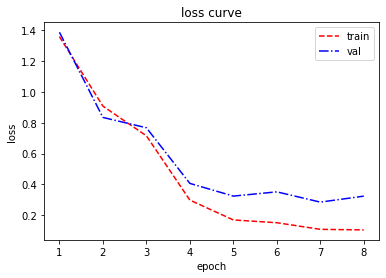

In [12]:
val_loss = []
train_loss = []

for epoch in range(8):  # loop over the trainset（45000 each epoch） multiple times
    running_train_loss = 0.0
    running_val_loss = 0.0
    scheduler.step()
    for i, data in enumerate(trainloader , 0):
        # get the inputs
        images, labels = data
        inputs, labels = images.cuda(),labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_train_loss += loss.item()
        if i % 500 == 499:    # print 1 epoch
             print('[%d, %5d] train_loss: %.3f' %
                  (epoch + 1, i + 1, running_train_loss / 500))
             train_loss.append(running_train_loss/500)
                
    for i, data in enumerate(testloader, 0):
        # get the inputs
        images, labels = data
        inputs, labels = images.cuda(),labels.cuda()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # print statistics
        running_val_loss += loss.item()
        if i % 88 == 87:    # print 1 epoch
             print('[%d, %5d] val_loss: %.3f' %
                  (epoch + 1, i + 1, running_val_loss /88))
             val_loss.append(running_val_loss/88)
             running_train_loss = 0.0
             running_val_loss = 0.0
             eval_net(net, testloader)
            
 
                
# functions to show the loss
t = np.arange(8)  

plt.plot(t+1, train_loss,color='red',linestyle='--')
plt.plot(t+1, val_loss,color='blue',linestyle='-.')

plt.title('loss curve')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [11]:
def eval_net(net, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            inputs, labels = images.cuda(),labels.cuda()
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%\n\n' % (
        100 * correct / total))

In [15]:
eval_net(net, testloader)

Accuracy of the network on the test images: 91 %




In [176]:
net.load_state_dict(torch.load('./project2.pth', map_location='cuda'))

    
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('Ground True: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# use the predefined network to give predictions 
outputs = net(images.cuda())
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Accuracy of the network on the 10000 test images: 38 %


